In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import laplace
from skimage import feature
from itertools import chain
import random

from load import *
from test import *

#plt.rcParams['figure.figsize'] = (16, 16)

In [2]:
"""TESTING AND EXAMPLE CODE BELOW"""
t = TestSet()
def predict_perfect(data):
    return t.labels
def predict_shift_3(data):
    return shift_rois(t.labels, 3)
def predict_shift_5(data): 
    return shift_rois(t.labels,5)
def predict_shift_15(data):
    return shift_rois(t.labels,15)   
            
def shift_rois(labels, shift_amt):
    new_labels = []
    for stack in labels:
        new_stack = np.zeros(stack.shape)
        for i,roi in enumerate(stack):
            new_stack[i] = np.roll(roi, shift_amt, axis=1)
        new_labels.append(new_stack)
    return new_labels

scores = [Score(predict_perfect, t), Score(predict_shift_3, t), 
          Score(predict_shift_5, t), Score(predict_shift_15, t)]


/Users/cyrilzhang/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/cyrilzhang/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/cyrilzhang/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/cyrilzhang/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/cyrilzhang/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [3]:
for s in scores:
    print str(s)


Total F1 Score      = 1.0
F1 Score per stack  = [1.0, 1.0]
Total Precision     = 1.0
Precision per stack = [1.0, 1.0]
Total Recall        = 1.0
Recall per stack    = [1.0, 1.0]
Overlap Boundary Quality, all stacks = {'std recall': 0.0, 'mean precision': 1.0, 'std precision': 0.0, 'mean recall': 1.0}
Overlap Boundary Quality, per stack  = [{'std recall': 0.0, 'mean precision': 1.0, 'std precision': 0.0, 'mean recall': 1.0}, {'std recall': 0.0, 'mean precision': 1.0, 'std precision': 0.0, 'mean recall': 1.0}]


Total F1 Score      = 0.992337164751
F1 Score per stack  = [0.9896907216494846, 0.9939024390243902]
Total Precision     = 0.992337164751
Precision per stack = [0.9896907216494846, 0.9939024390243902]
Total Recall        = 0.992337164751
Recall per stack    = [0.9896907216494846, 0.9939024390243902]
Overlap Boundary Quality, all stacks = {'std recall': 0.02398722978827976, 'mean precision': 0.75587293893328311, 'std precision': 0.02398722978827976, 'mean recall': 0.7558729389332831

Score Number in order of increasing recall: (2, 3, 1, 0)
Score number in order of increasing boundary recall: (2, 1, 3, 0)


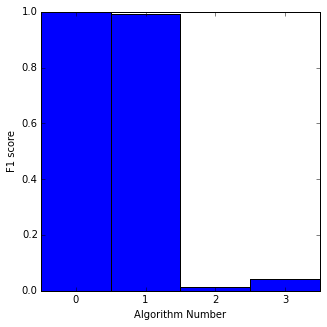

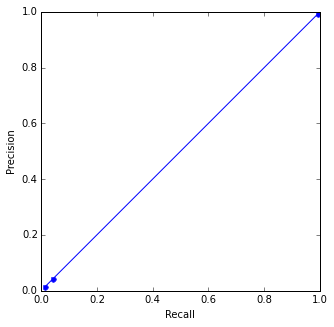

/Users/cyrilzhang/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


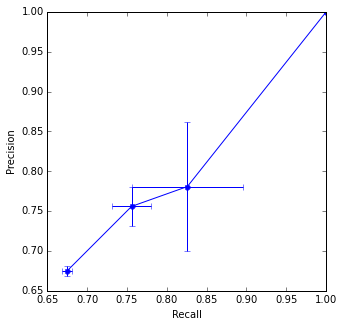

In [4]:
plt.rcParams['figure.figsize'] = (5, 5)
plot_multiple_scores(scores)